# Logistic Regression

    Notebook version: 1.0 (Oct 16, 2015)

    Author: Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Changes: v.1.0 - First version

In [18]:
# To visualize plots in the notebook
%matplotlib inline

# Imported libraries
import csv
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model

## 1. Introduction

### 1.1. Binary classification and decision theory

The goal of a classification problem is to assign a *class* or *category* to every *instance* or *observation* of a data collection. Here, we will assume that every instance ${\bf x}$ is an $N$-dimensional vector in $\mathbb{R}^N$, and that the class $y$ of sample ${\bf x}$ is an element of a binary set ${\mathcal Y} = \{0, 1\}$. The goal of a classifier is to predict the true value of $y$ after observing ${\bf x}$. We will denote as $\hat{y}$ the classifier output or *decision*. If $y=\hat{y}$, the decision is an *hit*, otherwise $y\neq \hat{y}$ and the decision is an *error*.

Decision theory provides a solution to the classification problem in situations where the relation between instance ${\bf x}$ and its class $y$ is given by a known probabilistic model: assume that every tuple $({\bf x}, y)$ is an outcome of a random vector $({\bf X}, Y)$ with joint distribution $p_{{\bf X},Y}({\bf x}, y)$. A natural criteria for classification is to select predictor $\hat{Y}=f({\bf x})$ in such a way that the probability or error, $P\{\hat{Y} \neq Y\}$ is minimum. Noting that
$$
P\{\hat{Y} \neq Y\} = \int P\{\hat{Y} \neq Y | {\bf x}\} p_{\bf X}({\bf x}) d{\bf x}
$$
the optimal decision is got if, for every sample ${\bf x}$, we make decision minimizing the condicional error probability:
\begin{align}
\hat{y}^* &= \arg\min_{\hat{y}} P\{\hat{y} \neq Y |{\bf x}\} \\
          &= \arg\max_{\hat{y}} P\{\hat{y} = Y |{\bf x}\} \\
\end{align}
Thus, the optimal decision rule can be expressed as
$$
P_{Y|X}(1|{\bf x}) \quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0}\quad  P_{Y|X}(0|{\bf x}) 
$$
or, equivalently
$$
P_{Y|X}(1|{\bf x}) \quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0}\quad  \frac{1}{2} 
$$
The classifier implementing this decision rule is usually named MAP (Maximum A Posterior). 

### 1.2. Parametric classification.

Classical decision theory is grounded on the assumption that the probabilistic model relating the observed sample ${\bf X}$ and the true hypothesis $Y$ is known. Unfortunately, this is unrealistic in many applications, where the only available information to construct the classifier is a dataset $\mathcal S = \{({\bf x}^{(k)}, y^{(k)}), \,k=1,\ldots,K\}$ of intances and their respective class labels.

A more realistic formulation of the classification problem is the following: given a dataset $\mathcal S = \{({\bf x}^{(k)}, y^{(k)}) \in {\mathbb{R}}^N \times {\mathcal Y}, \, k=1,\ldots,K\}$ of independent and identically distributed (i.i.d.) samples from an ***unknown*** distribution $p_{{\bf X},Y}({\bf x}, y)$, predict the class $y$ of a new sample ${\bf x}$ with the minimum probability of error.

Since the probabilistic model generating the data is unknown, the MAP decision rule cannot be applied. However, many classification algorithms use the dataset to obtain an estimate of the posterior class probabilities, and apply it to implement an approximation to the MAP decision maker.

Parametric classifiers based on this idea assume, additionally, that the posterior class probabilty satisfies some parametric formula:
$$
P_{Y|X}(1|{\bf x},{\bf w}) = f_{\bf w}({\bf x})
$$
where ${\bf w}$ is a vector of parameters. Therefore, the dataset ${\mathcal S}$ is used to compute an estimate $\hat{\bf w}$ of ${\bf w}$ and then apply the decision rule
$$
f_{\hat{\bf w}}({\bf x}) \quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0}\quad  \frac{1}{2} 
$$


In this lesson we explore one of the most popular model-based parametric classification methods: logistic regression.

## 2. Logistic regression.

### 2.1. The logistic function

The logistic regression model assumes that the binary class label $Y \in \{0,1\}$ of observation $X\in \mathbb{R}^N$ satisfies the expression.
$$p_{Y|{\bf X},W}(1|{\bf x}, {\bf w}) = f({\bf w}^\intercal{\bf x})$$
$$p_{Y|{\bf,X},W}(0|{\bf x}, {\bf w}) = 1-f({\bf w}^\intercal{\bf x})$$
where ${\bf w}$ is a parameter vector and $f(·)$ is the *logistic* function, which is defined by
$$f(t) = \frac{1}{1+\exp(-t)}$$

It is straightforward to see that the logistic function has the following properties:

- **P1**: Probabilistic output: $\quad 0 \le f(t) \le 1$
- **P2**: Symmetry: $\quad f(-t) = 1-f(t)$
- **P3**: Monotonicity: $\quad f'(t) = f(t)·(1-f(t)) \ge 0$

In the following we define a logistic function in python, and use it to plot a graphical representation.

**Exercise 1**: Verify properties P2 and P3.

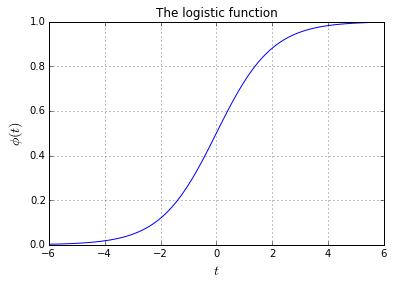

In [46]:
# Define the logistic function

def logistic(x):                                        
   p = 1.0 / (1 + np.exp(-x))
   return p

# Plot the logistic function
t = np.arange(-6, 6, 0.1)
z = logistic(t)

#z = np.divide(1.0, 1 + np.exp(-t))
plt.plot(t, z)
plt.xlabel('$t$', fontsize=14)
plt.ylabel('$\phi(t)$', fontsize=14)
plt.title('The logistic function')
plt.grid()

Noting that
$$p_{Y|{\bf,X},W}(0|{\bf x}, {\bf w}) = 1-f({\bf w}^\intercal{\bf x}) 
= f(-{\bf w}^\intercal{\bf x})$$
We can express the logistic model in compact form as
$$p_{Y|{\bf X},W}(y|{\bf x}, {\bf w}) = f(\overline{y}{\bf w}^\intercal{\bf x})$$
where $\overline{y} = 2y-1$ is a *symmetrized label* ($\overline{y}\in\{-1, 1\}$). This representation will be usefull for the derivation of logistic regression algorithms.


### 2.2. Classifiers based on the logistic model.

The MAP classifier unde a logistic model will have the form
$$p_{Y|{\bf X},W}(1|{\bf x}, {\bf w}) \quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0} \quad \frac{1}{2} $$
that is
$$f({\bf w}^\intercal{\bf x}) \quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0} \quad \frac{1}{2} $$
therefore
$$
2 \quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0} \quad  
1 + \exp(-{\bf w}^\intercal{\bf x}) $$
which is equivalent to
$${\bf w}^\intercal{\bf x} 
\quad\mathop{\gtrless}^{\hat{y}=1}_{\hat{y}=0}\quad 
0 $$
Therefore, the classifiers based on the logistic regression model are given by linear decision boundaries passing through the origin, ${\bf x} = {\bf 0}$. 

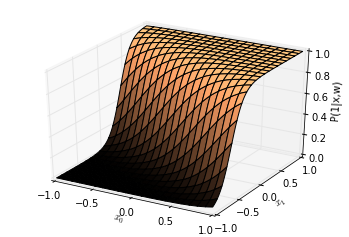

In [47]:
# Weight vector:
w = [1, 4, 8]   # Try different weights

# Create a regtangular grid.
x0_min = -1
x0_max = 1
x1_min = -1
x1_max = 1
dx0 = x0_max - x0_min
dx1 = x1_max - x1_min
h = float(dx0) / 200
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                       np.arange(x1_min, x1_max, h))

# Compute the logistic map for the given weights
Z = logistic(w[0] + w[1]*xx0 + w[2]*xx1)

# Plot the logistic map
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx0, xx1, Z, cmap=plt.cm.copper)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
ax.set_zlabel('P(1|x,w)')

### 3.3. Nonlinear classifiers.

The extension of the logistic model to construct non-linear classifiers is straightforward: we can construct non-linear classifiers with arbitrary decision boundaries by means of non-linear transformations of the data. A more general form for a nonlinear logistic regression model is
$$p_{Y|{\bf X},W}(1|{\bf x}, {\bf w}) = f({\bf w}^\intercal{\bf z}({\bf x})) $$
where ${\bf z}({\bf x})$ is an arbitrary nonlinear transformation. The boundary decision in that case is given by equation
$$
{\bf w}^\intercal{\bf z}({\bf x}) = 0
$$

** Exercise 2**: Modify the code above to generate a 3D surface plot of the polynomial logistic regression model given by
$$
P(1|{\bf x}) = f(1 + 10 x_0 + 10 x_1 - 20 x_0^2 + 5 x_0 x_1 + x_1^2) 
$$

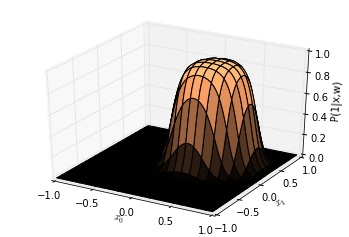

In [21]:
# SOLUTION TO THE EXERCISE
# Weight vector:
w = [1, 10, 10, -20, 5, 1]   # Try different weights

# Create a regtangular grid.
x0_min = -1
x0_max = 1
x1_min = -1
x1_max = 1
dx0 = x0_max - x0_min
dx1 = x1_max - x1_min
h = float(dx0) / 200
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                       np.arange(x1_min, x1_max, h))

# Compute the logistic map for the given weights
Z = logistic(w[0] + w[1]*xx0 + w[2]*xx1 + w[3]*np.multiply(xx0,xx0) + 
             w[4]*np.multiply(xx0,xx1) + w[3]*np.multiply(xx1,xx1))

# Plot the logistic map
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx0, xx1, Z, cmap=plt.cm.copper)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
ax.set_zlabel('P(1|x,w)')

## 3. Inference

Remember that the starting idea of parametric classification is to use data in a training set $\mathcal S = \{({\bf x}_k, y_k) \in {\mathbb{R}}^N \times \{0,1\}, k=1,\ldots,K\}$ to estimate the unknown parameter ${\bf w}$, and use the estimate $\hat{\bf w}$ to compute the label prediction for any new observation as 
$$\hat{y} = \arg\max_y P_{Y|{\bf X},{\bf W}}(y|{\bf x},\hat{\bf w}).$$
To do so, we will make the following assumptions:
- **A1**. The samples in ${\mathcal S}$ are i.i.d.
- **A2**. Target $Y^{(k)}$ only depends on ${\bf x}^{(k)}$, but not on ${\bf x}^{(l)}$ for any $l\neq k$.
- **A3**. (Logistic Regression): target $Y^{(k)}$ satisfies a logistic model: $P_{Y|{\bf X},{\bf W}}(1|{\bf x}, {\bf w}) = f({\bf w}^\intercal{\bf z}({\bf x}))$.

In the following we discuss different approaches to the estimation of ${\bf w}$.
* Maximum Likelihood (ML) estimat: ${\bf w}_{\text{ML}} = \arg\max_{\bf w} p_{{\mathcal S}|{\bf W}}({\mathcal S}|{\bf w})$
* Maximum A Posteriori estimate (MAP): ${\bf w}_{\text{MAP}} = \arg\max_{\bf w} p_{{\bf W}|{\mathcal S}}({\bf w}|{\mathcal S})$
* Bayesian estimate: ${\bf w}_{\text{B}} = \mathbb{E}\{{\bf W}|{\mathcal S}\}$

### 3.1. ML estimation.

The ML estimate is defined as
$${\bf w}_{\text{ML}}
   = \arg\min_{\bf w} L({\bf w})
$$
where $L({\bf w})$ is the negative log-likelyhood function, given by
$$
L({\bf w}) = - \log\left(p\left(y^{(1)},\ldots,y^{(K)}|
     {\bf x}^{(1)},\ldots, {\bf x}^{(K)},{\bf w}\right)\right)
$$
This function can be computed as follows. Using assumption A1:
$$
L({\bf w}) = - \log\left(\prod_{k=1}^K p\left(y^{(k)}|{\bf x}^{(1)},\ldots,{\bf x}^{(K)},{\bf w}\right)\right),
$$
using A2:
\begin{align}
L({\bf w}) 
    &= - \log\left(\prod_{k=1}^K p_{Y|{\bf X},{\bf W}}\left(y^{(k)}|{\bf x}^{(k)},{\bf w}\right)\right) \\
    &= - \sum_{k=1}^K\log\left(p_{Y|{\bf X},{\bf W}}\left(y^{(k)}|{\bf x}^{(k)},{\bf w}\right)\right)
\end{align}
and, using A3 (the logistic model)
\begin{align}
L({\bf w}) 
    &= - \sum_{k=1}^K\log\left(f\left(\overline{y}^{(k)}{\bf w}^\intercal {\bf z}^{(k)}\right)\right)   \\
    &= \sum_{k=1}^K\log\left(1+\exp\left(-\overline{y}^{(k)}{\bf w}^\intercal {\bf z}^{(k)}\right)\right)
\end{align}
where ${\bf z}^{(k)}={\bf z}({\bf x}^{(k)})$.

It can be shown that $L({\bf w})$ is a convex and differentiable function of ${\bf w}$. Therefore, its minimum is a point with zero gradient.

\begin{align}
\nabla_{\bf w} L(\hat{\bf w}_{\text{ML}}) 
    &= - \sum_{k=1}^K 
       \frac{\exp\left(-\overline{y}^{(k)}\hat{\bf w}_{\text{ML}}^\intercal {\bf z}^{(k)}\right) \overline{y}^{(k)} {\bf z}^{(k)}}
       {1+\exp\left(-\overline{y}^{(k)}\hat{\bf w}_{\text{ML}}^\intercal {\bf z}^{(k)}
       \right)} = \\
    &= - \sum_{k=1}^K \left(y^{(k)}-f(\hat{\bf w}_{\text{ML}}^T {\bf z}^{(k)})\right) {\bf z}^{(k)} = 0
\end{align}

Unfortunately, $\hat{\bf w}_{\text{ML}}$ cannot be taken out from the above equation, and some iterative optimization algorithm must be used to estimate the minimum.

### 3.2. Gradient descent.

A simple iterative optimization algorithm is gradient descent. 
\begin{align}
{\bf w}_{n+1} = {\bf w}_n - \rho_n \nabla_{\bf w} L({\bf w}_n)
\end{align}
where $\rho_n >0$ is the *learning step*.

Applying the gradient descent rule to logistic regression, we get the following algorithm:
\begin{align}
{\bf w}_{n+1} &= {\bf w}_n 
    + \rho_n \sum_{k=1}^K \left(y^{(k)}-f({\bf w}_n^T {\bf z}^{(k)})\right) {\bf z}^{(k)}
\end{align}
Defining vectors
\begin{align}
{\bf y} &= (y^{(1)},\ldots,y^{(K)})^\intercal \\
\hat{\bf p}_n &= (f({\bf w}_n^T {\bf x}^{(1)}), \ldots, f({\bf w}_n^T {\bf z}^{(K)}))^\intercal
\end{align}
and matrix
\begin{align}
{\bf Z} = \left({\bf z}^{(1)},\ldots,{\bf z}^{(K)}\right)^\intercal
\end{align}
we can write
\begin{align}
{\bf w}_{n+1} &= {\bf w}_n 
    + \rho_n {\bf Z}^\intercal \left({\bf y}-\hat{\bf p}_n\right)
\end{align}

In the following, we will explore the behavior of the gradient descend method using the Iris Dataset.

#### 3.2.1 Example: Iris Dataset.

As an illustration, consider the <a href = http://archive.ics.uci.edu/ml/datasets/Iris> Iris dataset </a>, taken from the <a href=http://archive.ics.uci.edu/ml/> UCI Machine Learning repository</a>. This data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant (*setosa*, *versicolor* or *virginica*). Each instance contains 4 measurements of given flowers: sepal length, sepal width, petal length and petal width, all in centimeters. 

We will try to fit the logistic regression model to discriminate between two classes using only two attributes.

First, we load the dataset and split them in training and test subsets.

In [51]:
# Adapted from a notebook by Jason Brownlee
def loadDataset(filename, split):
    xTrain = []
    cTrain = []
    xTest = []
    cTest = []

    with open(filename, 'rb') as csvfile:
        lines = csv.reader(csvfile)
        dataset = list(lines)
    for i in range(len(dataset)-1):
        for y in range(4):
            dataset[i][y] = float(dataset[i][y])
        item = dataset[i]
        if random.random() < split:
            xTrain.append(item[0:4])
            cTrain.append(item[4])
        else:
            xTest.append(item[0:4])
            cTest.append(item[4])
    return xTrain, cTrain, xTest, cTest

with open('iris.data', 'rb') as csvfile:
	lines = csv.reader(csvfile)

xTrain_all, cTrain_all, xTest_all, cTest_all = loadDataset('iris.data', 0.66)
nTrain_all = len(xTrain_all)
nTest_all = len(xTest_all)
print 'Train: ' + str(nTrain_all)
print 'Test: ' + str(nTest_all)

Train: 102
Test: 48


Now, we select two classes and two attributes.

In [52]:
# Select attributes
i = 0 # Try 0,1,2,3
j = 1 # Try 0,1,2,3 with j!=i

# Select two classes
c0 = 'Iris-versicolor' 
c1 = 'Iris-virginica'

# Select two coordinates
ind = [i, j]

# Take training test
X_tr = np.array([[xTrain_all[n][i] for i in ind] for n in range(nTrain_all) 
                  if cTrain_all[n]==c0 or cTrain_all[n]==c1])
C_tr = [cTrain_all[n] for n in range(nTrain_all) 
          if cTrain_all[n]==c0 or cTrain_all[n]==c1]
Y_tr = np.array([int(c==c1) for c in C_tr])
n_tr = len(X_tr)

# Take test set
X_tst = np.array([[xTest_all[n][i] for i in ind] for n in range(nTest_all) 
                 if cTest_all[n]==c0 or cTest_all[n]==c1])
C_tst = [cTest_all[n] for n in range(nTest_all) 
         if cTest_all[n]==c0 or cTest_all[n]==c1]
Y_tst = np.array([int(c==c1) for c in C_tst])
n_tst = len(X_tst)

#### 3.2.2. Data normalization

Normalization of data is a common pre-processing step in many machine learning algorithms. Its goal is to get a dataset where all input coordinates have a similar scale. Learning algorithms usually show less instabilities and convergence problems when data are normalized.

We will define a normalization function that returns a training data matrix with zero sample mean and unit sample variance.

In [53]:
def normalize(X, mx=None, sx=None):
    
    # Compute means and standard deviations
    if mx is None:
        mx = np.mean(X, axis=0)
    if sx is None:
        sx = np.std(X, axis=0)

    # Normalize
    X0 = (X-mx)/sx

    return X0, mx, sx

Now, we can normalize training and test data. Observe in the code that the same transformation should be applied to training and test data. This is the reason why normalization with the test data is done using the mean and the variance computed with the training set.

In [54]:
# Normalize data
Xn_tr, mx, sx = normalize(X_tr)
Xn_tst, mx, sx = normalize(X_tst, mx, sx)

The following figure generates a plot of the normalized training data.

(-3.0, 3.0, -3.0, 3.0)

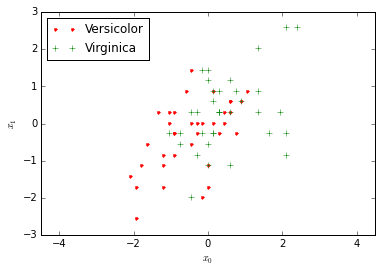

In [55]:
# Separate components of x into different arrays (just for the plots)
x0c0 = [Xn_tr[n][0] for n in range(n_tr) if Y_tr[n]==0]
x1c0 = [Xn_tr[n][1] for n in range(n_tr) if Y_tr[n]==0]
x0c1 = [Xn_tr[n][0] for n in range(n_tr) if Y_tr[n]==1]
x1c1 = [Xn_tr[n][1] for n in range(n_tr) if Y_tr[n]==1]

# Scatterplot.
labels = {'Iris-setosa': 'Setosa', 
          'Iris-versicolor': 'Versicolor',
          'Iris-virginica': 'Virginica'}
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')
plt.axis('equal')

In order to apply the gradient descent rule, we need to define two methods: 
 - A `fit` method, that receives the training data and returns the model weights and the value of the negative log-likelihood during all iterations.
 - A `predict` method, that receives the model weight and a set of inputs, and returns the posterior class probabilities for that input, as well as their corresponding class predictions.

In [56]:
def logregFit(Z_tr, Y_tr, rho, n_it):

    # Compute Z's
    n_dim = Z_tr.shape[1]

    # Initialize variables
    nll_tr = np.zeros(n_it)
    pe_tr = np.zeros(n_it)
    w = np.random.randn(n_dim,1)

    # Running the gradient descent algorithm
    for n in range(n_it):
        p_tr = logistic(np.dot(Z_tr, w))

        # Compute negative log-likelihood
        nll_tr[n] = - np.dot(Y_tr.T, np.log(p_tr)) - np.dot((1-Y_tr).T, np.log(1-p_tr))

        # Update weights
        w += rho*np.dot(Z_tr.T, Y_tr - p_tr)

    return w, nll_tr

def logregPredict(Z, w):

    # Compute posterior probability of class 1 for weights w.
    p = logistic(np.dot(Z, w))
    
    # Class
    D = [int(round(pn)) for pn in p]
    
    return p, D

We can test the behavior of the gradient descent method by fitting a logistic regression model with ${\bf z}({\bf x}) = (1, {\bf x}^\intercal)^\intercal$.

The optimal weights are:
[[-0.02407127]
 [ 1.17652106]
 [ 0.21655684]]
The final error rates are:
- Training: 0.295774647887
- Test: 0.241379310345


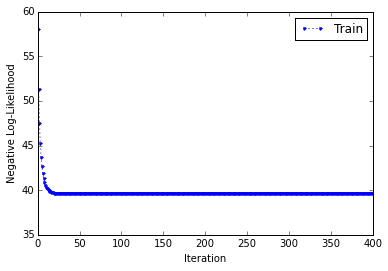

In [57]:
# Parameters of the algorithms
rho = float(1)/50    # Learning step
n_it = 400   # Number of iterations

# Compute Z's
Z_tr = np.c_[np.ones(n_tr), Xn_tr] 
Z_tst = np.c_[np.ones(n_tst), Xn_tst]
n_dim = Z_tr.shape[1]

# Convert target arrays to column vectors
Y_tr2 = Y_tr[np.newaxis].T
Y_tst2 = Y_tst[np.newaxis].T

# Running the gradient descent algorithm
w, nll_tr = logregFit(Z_tr, Y_tr2, rho, n_it)

# Classify training and test data
p_tr, D_tr = logregPredict(Z_tr, w)
p_tst, D_tst = logregPredict(Z_tst, w)
    
# Compute error rates
E_tr = D_tr!=Y_tr
E_tst = D_tst!=Y_tst

# Error rates
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst

# NLL plot.
plt.plot(range(n_it), nll_tr,'b.:', label='Train')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood')
plt.legend()

print "The optimal weights are:"
print w
print "The final error rates are:"
print "- Training: " + str(pe_tr)
print "- Test: " + str(pe_tst)

#### 3.2.3. Free parameters

Under certaing conditions, the gradient descent method can be shown to converge assymtotically (i.e. as the number of iterations goes to infinity) to the ML estimate of the logistic model. However, in practice, the final estimate of the weights ${\bf w}$ depend on several factors:

- Number of iterations
- Initialization
- Learning step

**Exercise**: Visualize the variability of gradient descent caused by initializations. To do so, fix the number of iterations to 200 and the learning step, and execute the gradient descent 100 times, storing the training error rate of each execution. Plot the histogram of the error rate values.

Note that you can do this exercise with a loop over the 100 executions, including the code in the previous code slide inside the loop, with some proper modifications. To plot a histogram of the values in array `p` with `n`bins, you can use `plt.hist(p, n)`

##### 4.2.3.1. Learning step

The learning step, $\rho$, is a free parameter of the algorithm. Its choice is critical for the convergence of the algorithm. Too large values of $\rho$ make the algorithm diverge. For too small values, the convergence is too slown and more iterations are required for a good convergence.


**Exercise 3**: Observe the evolution of the negative log-likelihood with the number of iterations, for different values of $\rho$. It is easy to check that, for $\rho$ large enough, the gradient descent method does not converge. Can you estimate (through manual observation) and approximate value of $\rho$ stating a boundary between convergence and non-convergence?

**Exercise 4**: In this exercise we explore the influence of the learning step more sistematically. Use the code in the previouse exercises to compute, for every value of $\rho$, the average error rate over 100 executions. Plot the average error rate vs. $\rho$. 

Note that you should explore the values of $\rho$ in a logarithmic scale. For instance, you can take $\rho = 1, 1/10, 1/100, 1/1000, \ldots$

In practice, the selection of $\rho$ may be a matter of trial an error. Also there is some theoretical evidence that the learning step should decrease along time up to cero, and the sequence $\rho_n$ should satisfy two conditions:
- C1: $\sum_{n=0}^{\infty} \rho_n = \infty$ (decrease slowly)
- C2: $\sum_{n=0}^{\infty} \rho_n^2 < \infty$ (do not decrease too much slowly)

For instance, we can take $\rho_n= 1/n$. Another common choice is $\rho_n = \alpha/(1+\beta n)$ where $\alpha$ and $\beta$ are also free parameters that can be selected by trial and error with some heuristic method.

#### 4.2.4. Visualizing the posterior map.

We can also visualize the posterior probability map estimated by the logistic regression model for the estimated weights.

<matplotlib.contour.QuadContourSet instance at 0x10c1c4f80>

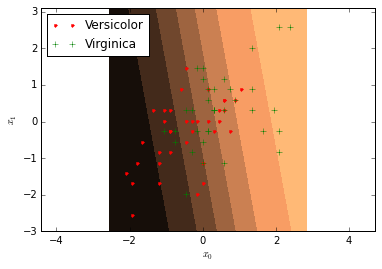

In [58]:
# Create a regtangular grid.
x_min, x_max = Xn_tr[:, 0].min(), Xn_tr[:, 0].max() 
y_min, y_max = Xn_tr[:, 1].min(), Xn_tr[:, 1].max()
dx = x_max - x_min
dy = y_max - y_min
h = dy / 500
xx, yy = np.meshgrid(np.arange(x_min - 0.1 * dx, x_max + 0.1 * dx, h),
                     np.arange(y_min - 0.1 * dx, y_max + 0.1 * dy, h))
X_grid = np.array([xx.ravel(), yy.ravel()]).T

# Compute Z's
Z_grid = np.c_[np.ones(X_grid.shape[0]), X_grid] 

# Compute the classifier output for all samples in the grid.
pp = logistic(np.dot(Z_grid, w))

# Put the result into a color plot
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')
plt.axis('equal')
pp = pp.reshape(xx.shape)
plt.contourf(xx, yy, pp, cmap=plt.cm.copper)

The optimal weights are:
[[-1.21792466]
 [-2.15979146]
 [-1.77780269]
 [ 0.51532146]
 [ 0.9359526 ]
 [-0.35799002]]
The final error rates are:
- Training: 0.323943661972
- Test: 0.344827586207


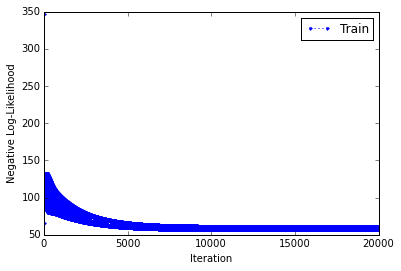

In [59]:
# Parameters of the algorithms
rho = float(1)/10000    # Learning step
n_it = 20000   # Number of iterations

# Compute Z's
Z_tr = np.c_[np.ones(n_tr), X_tr, np.power(X_tr, 2), np.prod(X_tr,1)] 
Z_tst = np.c_[np.ones(n_tst), X_tst, np.power(X_tst, 2), np.prod(X_tst,1)]
n_dim = Z_tr.shape[1]

# Convert target arrays to column vectors
Y_tr2 = Y_tr[np.newaxis].T
Y_tst2 = Y_tst[np.newaxis].T

# Running the gradient descent algorithm
w, nll_tr = logregFit(Z_tr, Y_tr2, rho, n_it)

# Classify training and test data
p_tr, D_tr = logregPredict(Z_tr, w)
p_tst, D_tst = logregPredict(Z_tst, w)
    
# Compute error rates
E_tr = D_tr!=Y_tr
E_tst = D_tst!=Y_tst

# Error rates
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst

# NLL plot.
plt.plot(range(n_it), nll_tr,'b.:', label='Train')
plt.xlabel('Iteration')
plt.ylabel('Negative Log-Likelihood')
plt.legend()

print "The optimal weights are:"
print w
print "The final error rates are:"
print "- Training: " + str(pe_tr)
print "- Test: " + str(pe_tst)

Visualizing the posterior map we can se that the polynomial transformations produces nonlinear decision boundaries.

<matplotlib.contour.QuadContourSet instance at 0x11812acf8>

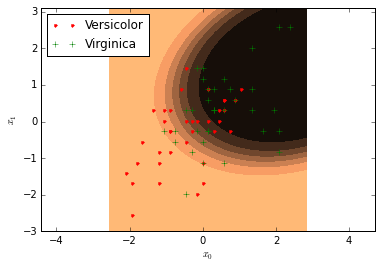

In [60]:
# Compute Z's
Z_grid = np.c_[np.ones(X_grid.shape[0]), X_grid, np.power(X_grid, 2), np.prod(X_grid,1)] 

# Compute the classifier output for all samples in the grid.
pp = logistic(np.dot(Z_grid, w))

# Put the result into a color plot
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')
plt.axis('equal')

pp = pp.reshape(xx.shape)
plt.contourf(xx, yy, pp, cmap=plt.cm.copper)

## 4. Other optimization algorithms

### 4.1. Stochastic Gradient descent.

Stochastic gradient descent (SGD) is based on the idea of using a single sample at each iteration of the learning algorithm. The SGD rule for logistic regression is
\begin{align}
{\bf w}_{n+1} &= {\bf w}_n 
    + \rho_n {\bf z}^{(n)} \left(y^{(n)}-\hat{p}^{(n)}_n\right)
\end{align}
Once all samples in the training set have been applied, the algorith can continue by applying the training set several times.

The computational cost of each iteration of SGD is much smaller than that of gradient descent, though it usually needs more iterations to converge.

### 4.2. The Newton's method

In the Newton's method, at each optization step, the function to be minimized is approximated by a second order approximation using a taylor series expansion around the current estimate. As a result, the update direction of the iterative rule is modified by the hessian matrix of the function to be minimized. Its general form is:
$$\hat{\bf w}_{n+1} = \hat{\bf w}_{n} - \rho_n {\bf H}({\bf w}_k)^{-1} \nabla_{{\bf w}}L({\bf w}_k)
$$
where ${\bf H}({\bf w}_k)$ is the hessian matrix of $L$ at ${\bf w}_k$, which is given by $${\bf H}({\bf w}) 
  = - \sum_{k=1}^K f({\bf w}^T {\bf x}^{(k)}) \left(1-f({\bf w}^T {\bf x}^{(k)}\right){\bf x}^{(k)} ({\bf x}^{(k)})^\intercal
$$
Some variants of the Newton method are implemented in the Scikit-learn package<a href="http://scikit-learn.org/stable/"> scikit-learn </a> package for Python.



**Exercise 5**: Modify logregFit to implement an algorithm that applies the SGD rule one to every sample in the training set.

## 5. Regularization and MAP estimation.

An alternative to the ML estimation of the weights in logistic regression is Maximum A Posteriori estimation. Modelling the logistic regression weights as a random variable with prior distribution $p_{\bf W}({\bf w})$, the MAP estimate is defined as

$$
\hat{\bf w}_{\text{MAP}} = \arg\max p({\bf w}|{\mathcal S})
$$

The posterior density $p({\bf w}|{\mathcal S})$ is related to the likelihood function and the prior density of the weights, $p_{\bf W}({\bf w})$ through the Bayes rule

$$
p({\bf w}|{\mathcal S}) = 
    \frac{p\left(y^{(1)},\ldots,y^{(K)}|{\bf x}^{(1)},\ldots, {\bf x}^{(K)},{\bf w}\right)
          p_{\bf W}({\bf w})}
         {p\left(y^{(1)},\ldots,y^{(K)}|{\bf x}^{(1)},\ldots, {\bf x}^{(K)}\right)}
$$

In general, the denominator in this expression cannot be computed analytically. However, it is not required for MAP estimation because it does not depend on ${\bf w}$. Thus, we can compute the MAP estimate as
\begin{align}
\hat{\bf w}_{\text{MAP}} 
  &= \arg\max_{\bf w} 
         p\left(y^{(1)},\ldots,y^{(K)}|{\bf x}^{(1)},\ldots, {\bf x}^{(K)},{\bf w}\right) 
         p_{\bf W}({\bf w}) \\
  &= \arg\max_{\bf w} \left\{
         \log\left(p\left(y^{(1)},\ldots,y^{(K)}|{\bf x}^{(1)},\ldots, {\bf x}^{(K)},{\bf w}\right) \right)
         + \log\left( p_{\bf W}({\bf w})\right)
         \right\}  \\
  &= \arg\min_{\bf w} \left\{L({\bf w}) - \log\left( p_{\bf W}({\bf w})\right)
         \right\}
\end{align}
where $L(·)$ is the negative log-likelihood function.
Two common choices for the prior are

- **Gaussian**: ${\bf W}$ is a zero-mean Gaussian random variable with variance matrix $v{\bf I}$. Thus: 
$$
p_{\bf W}({\bf w}) = \frac{1}{(2\pi v)^{N/2}} \exp\left(-\frac{1}{2v}\|{\bf w}\|^2\right)
$$
and the MAP estimate is
\begin{align}
\hat{\bf w}_{\text{MAP}} 
  &= \arg\min_{\bf w} \left\{L({\bf w}) + \frac{1}{C}\|{\bf w}\|^2
         \right\}
\end{align}
where $C = 2v$.
- **Laplacian**: ${\bf W}$ is a multivariate zero-mean Laplacian distribution given by
$$
p_{\bf W}({\bf w}) = \frac{1}{(2 C)^{N}} \exp\left(-\frac{1}{C}\|{\bf w}\|_1\right)
$$
(where $\|{\bf w}\|=|w_1|+\ldots+|w_N|$ is the $L_1$ norm of ${\bf w}$) and the MAP estimate is
\begin{align}
\hat{\bf w}_{\text{MAP}} 
  &= \arg\min_{\bf w} \left\{L({\bf w}) + \frac{1}{C}\|{\bf w}\|_1
         \right\}
\end{align}

The additional term introduced by the prior in the optimization algorithm is usually named the *regularization term*. It is usually very effective to avoid overfitting when the dimension of the weight vectors is high. Parameter $C$ is named the *inverse regularization strength*.

**Exercise 6**: Derive the gradient descent rules for MAP estimation of the logistic regression weights with (a) Gaussian prior, and (b) Laplacian prior.

## 6. Logistic regression in Scikit Learn.

The <a href="http://scikit-learn.org/stable/"> scikit-learn </a> package includes an efficient implementation of <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression"> logistic regression</a>. To use it, we must first create a classifier object, specifying the parameters of the logistic regression algorithm.

The final error rates are:
- Training: 0.295774647887
- Test: 0.275862068966


<matplotlib.contour.QuadContourSet instance at 0x115b348c0>

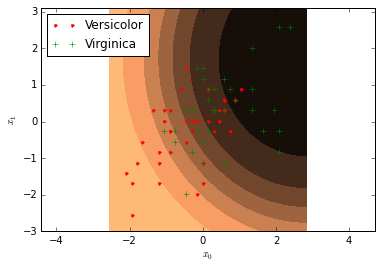

In [61]:
# Create a logistic regression object.
LogReg = linear_model.LogisticRegression(C=1.0)

# Training
LogReg.fit(Z_tr, Y_tr)

# Predict classes
D_tr = LogReg.predict(Z_tr)
D_tst = LogReg.predict(Z_tst)

# Compute error rates
E_tr = D_tr!=Y_tr
E_tst = D_tst!=Y_tst

# Error rates
pe_tr = float(sum(E_tr)) / n_tr
pe_tst = float(sum(E_tst)) / n_tst

print "The final error rates are:"
print "- Training: " + str(pe_tr)
print "- Test: " + str(pe_tst)

# Compute the classifier output for all samples in the grid.
pp = LogReg.predict_proba(Z_grid)[:,1]

# Put the result into a color plot
plt.plot(x0c0, x1c0,'r.', label=labels[c0])
plt.plot(x0c1, x1c1,'g+', label=labels[c1])
plt.xlabel('$x_' + str(ind[0]) + '$')
plt.ylabel('$x_' + str(ind[1]) + '$')
plt.legend(loc='best')
plt.axis('equal')
pp = pp.reshape(xx.shape)
plt.contourf(xx, yy, pp, cmap=plt.cm.copper)
